In [2]:
 pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install multiscorer

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement multiscorer (from versions: none)
ERROR: No matching distribution found for multiscorer


In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objs as go 

# avoid displaying warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans
import xgboost as xgb
import time

In [5]:
df= pd.read_csv("C:\\Users\\LAU\\Desktop\\new proj\\base_data_new_25_new.csv")


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406829 entries, 0 to 406828
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   InvoiceNo         406829 non-null  int64  
 1   Description       406829 non-null  object 
 2   Quantity          406829 non-null  int64  
 3   InvoiceDate       406829 non-null  object 
 4   UnitPrice         406829 non-null  float64
 5   CustomerID        406829 non-null  int64  
 6   Country           406829 non-null  object 
 7   date              406829 non-null  object 
 8   Recency           406829 non-null  int64  
 9   Frequency         406829 non-null  int64  
 10  Total_cost        406829 non-null  float64
 11  Monetary          406829 non-null  int64  
 12  receny_score      406829 non-null  int64  
 13  frequency_score   406829 non-null  int64  
 14  monetary_score    406829 non-null  int64  
 15  customer_segment  406829 non-null  int64  
dtypes: float64(2), int64

In [7]:
df.isnull().sum()


InvoiceNo           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID          0
Country             0
date                0
Recency             0
Frequency           0
Total_cost          0
Monetary            0
receny_score        0
frequency_score     0
monetary_score      0
customer_segment    0
dtype: int64

In [8]:
df.InvoiceDate = pd.to_datetime(df.InvoiceDate,format='mixed')


In [9]:
pd.DataFrame(df.InvoiceDate.describe())


,InvoiceDate
count,406829
mean,2011-07-10 16:30:57.879207424
min,2010-12-01 08:26:00
25%,2011-04-06 15:02:00
50%,2011-07-31 11:48:00
75%,2011-10-20 13:06:00
max,2011-12-09 12:50:00


In [10]:
df.head()


,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,Recency,Frequency,Total_cost,Monetary,receny_score,frequency_score,monetary_score,customer_segment
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,325,35,15.30,5289,5,5,4,2
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2,35,20.34,5289,1,5,4,5
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,75,35,22.00,5289,1,5,4,5
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,18,35,20.34,5289,1,5,4,5
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,310,35,20.34,5289,5,5,4,2


In [11]:
ctm = df[(df.InvoiceDate < pd.Timestamp(2011,9,1)) & 
      (df.InvoiceDate >= pd.Timestamp(2010,1,1))].reset_index(drop=True)


In [12]:
next_qua = df[(df.InvoiceDate < pd.Timestamp(2011,12,1)) & 
      (df.InvoiceDate >= pd.Timestamp(2011,9,1))].reset_index(drop=True)

In [13]:
ctm = pd.DataFrame(ctm['CustomerID'].unique())

# Rename the column to CustomerID.
ctm.columns = ['CustomerID']

ctm.head()

,CustomerID
0,17850
1,13047
2,12583
3,13748
4,15100


In [14]:
print(ctm.columns)


Index(['CustomerID'], dtype='object')


In [15]:
ctm_1st_purchase_in_next_quarter = next_qua.groupby('CustomerID').InvoiceDate.min().reset_index()
ctm_1st_purchase_in_next_quarter.columns = ['CustomerID','MinPurchaseDate']
ctm_1st_purchase_in_next_quarter.head()

,CustomerID,MinPurchaseDate
0,12347,2011-10-31 12:25:00
1,12348,2011-09-25 13:13:00
2,12349,2011-11-21 09:51:00
3,12352,2011-09-20 14:34:00
4,12356,2011-11-17 08:40:00


In [16]:
ctm_last_purchase_bhvr_dt = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
ctm_last_purchase_bhvr_dt.columns = ['CustomerID','MaxPurchaseDate']
ctm_last_purchase_bhvr_dt.head()

,CustomerID,MaxPurchaseDate
0,12346,2011-01-18 10:17:00
1,12347,2011-12-07 15:52:00
2,12348,2011-09-25 13:13:00
3,12349,2011-11-21 09:51:00
4,12350,2011-02-02 16:01:00


In [17]:
ctm_purchase_dates = pd.merge(ctm_last_purchase_bhvr_dt, ctm_1st_purchase_in_next_quarter, on='CustomerID', 
                              how='left')
ctm_purchase_dates.head()

,CustomerID,MaxPurchaseDate,MinPurchaseDate
0,12346,2011-01-18 10:17:00,NaT
1,12347,2011-12-07 15:52:00,2011-10-31 12:25:00
2,12348,2011-09-25 13:13:00,2011-09-25 13:13:00
3,12349,2011-11-21 09:51:00,2011-11-21 09:51:00
4,12350,2011-02-02 16:01:00,NaT


In [18]:
ctm_purchase_dates['NextPurchaseDay'] = abs(ctm_purchase_dates['MinPurchaseDate'] - ctm_purchase_dates['MaxPurchaseDate']).dt.days

ctm_purchase_dates.head()

,CustomerID,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
0,12346,2011-01-18 10:17:00,NaT,NaN
1,12347,2011-12-07 15:52:00,2011-10-31 12:25:00,37.0
2,12348,2011-09-25 13:13:00,2011-09-25 13:13:00,0.0
3,12349,2011-11-21 09:51:00,2011-11-21 09:51:00,0.0
4,12350,2011-02-02 16:01:00,NaT,NaN


In [19]:
ctm_dt = pd.merge(ctm, ctm_purchase_dates[['CustomerID','NextPurchaseDay']], on='CustomerID', how='left')
ctm_dt.head()

,CustomerID,NextPurchaseDay
0,17850,NaN
1,13047,25.0
2,12583,76.0
3,13748,0.0
4,15100,NaN


In [20]:
ctm_dt = ctm_dt.fillna(9999)
ctm_dt.head()

,CustomerID,NextPurchaseDay
0,17850,9999.0
1,13047,25.0
2,12583,76.0
3,13748,0.0
4,15100,9999.0


In [21]:
ctm_max_purchase = df.groupby('CustomerID').InvoiceDate.max().reset_index()
ctm_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
ctm_max_purchase.head()

,CustomerID,MaxPurchaseDate
0,12346,2011-01-18 10:17:00
1,12347,2011-12-07 15:52:00
2,12348,2011-09-25 13:13:00
3,12349,2011-11-21 09:51:00
4,12350,2011-02-02 16:01:00


In [22]:
ctm_max_purchase['Recency'] = (ctm_max_purchase['MaxPurchaseDate'].max() - ctm_max_purchase['MaxPurchaseDate']).dt.days

# Merge the dataframes ctm_dt and ctm_max_purchase[['CustomerID', 'Recency']] on the CustomerID column.
ctm_dt = pd.merge(ctm_dt, ctm_max_purchase[['CustomerID', 'Recency']], on='CustomerID')
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency
0,17850,9999.0,301
1,13047,25.0,31
2,12583,76.0,2
3,13748,0.0,95
4,15100,9999.0,329


In [23]:
pd.DataFrame(ctm_dt.Recency.describe())


,Recency
count,3360.000000
mean,107.606845
std,108.717980
min,0.000000
25%,17.000000
50%,63.000000
75%,184.000000
max,373.000000


In [24]:
pip install --upgrade nbformat


In [25]:
pip install nbformat


Note: you may need to restart the kernel to use updated packages.


In [26]:
import plotly.io as pio
my_dict={}
ctm_recency = ctm_dt[['Recency']]
for idx in range(1, 10):
    kmeans = KMeans(n_clusters=idx, max_iter=1000).fit(ctm_recency)
    ctm_recency["clusters"] = kmeans.labels_
    my_dict[idx] = kmeans.inertia_ 

line_fig = px.line(x=list(my_dict.keys()), 
                   y=list(my_dict.values()), 
                   template="plotly_dark"
                  )

line_fig.update_layout(title_x=0, 
                       xaxis_title="Number of cluster", 
                       yaxis_title=""
                      )



In [27]:
pip show nbformat


Name: nbformat
Version: 5.10.4
Summary: The Jupyter Notebook format
Home-page: 
Author: 
Author-email: Jupyter Development Team <jupyter@googlegroups.com>
License: BSD 3-Clause License

- Copyright (c) 2001-2015, IPython Development Team
- Copyright (c) 2015-, Jupyter Development Team

All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS

In [28]:
number_of_clusters = 3


In [29]:
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Recency']])
ctm_dt['RecencyCluster'] = kmeans.predict(ctm_dt[['Recency']])
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster
0,17850,9999.0,301,1
1,13047,25.0,31,0
2,12583,76.0,2,0
3,13748,0.0,95,2
4,15100,9999.0,329,1


In [30]:
def order_cluster(df, target_field_name, cluster_field_name, ascending):
    
    new_cluster_field_name = "new_" + cluster_field_name
    
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    
    df_new["index"] = df_new.index
    
    df_final = pd.merge(df, df_new[[cluster_field_name, "index"]], on=cluster_field_name)
    
    df_final = df_final.drop([cluster_field_name], axis=1)
    
    df_final = df_final.rename(columns={"index": cluster_field_name})
    
    return df_final


In [31]:
ctm_dt = order_cluster(ctm_dt, 'Recency', 'RecencyCluster', False)
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster
0,17850,9999.0,301,0
1,13047,25.0,31,2
2,12583,76.0,2,2
3,13748,0.0,95,1
4,15100,9999.0,329,0


In [32]:
ctm_dt.groupby('RecencyCluster')['Recency'].describe()


,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,634.0,294.372240,45.419375,224.0,256.0,287.0,329.0,373.0
1,795.0,153.030189,37.863790,91.0,119.0,153.0,185.0,222.0
2,1931.0,27.585707,24.281196,0.0,8.0,21.0,43.0,90.0


In [33]:
ctm_frequency = df.groupby('CustomerID').InvoiceDate.count().reset_index()
ctm_frequency.columns = ['CustomerID','Frequency']

In [34]:
ctm_dt = pd.merge(ctm_dt, ctm_frequency, on='CustomerID')

ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency
0,17850,9999.0,301,0,312
1,13047,25.0,31,2,196
2,12583,76.0,2,2,251
3,13748,0.0,95,1,28
4,15100,9999.0,329,0,6


In [35]:
pd.DataFrame(ctm_dt.Frequency.describe())


,Frequency
count,3360.000000
mean,107.912202
std,261.386351
min,1.000000
25%,19.000000
50%,50.000000
75%,119.000000
max,7983.000000


In [36]:
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Frequency']])
ctm_dt['FrequencyCluster'] = kmeans.predict(ctm_dt[['Frequency']])

In [37]:
ctm_dt = order_cluster(ctm_dt, 'Frequency', 'FrequencyCluster', False)
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster
0,17850,9999.0,301,0,312,1
1,13047,25.0,31,2,196,2
2,12583,76.0,2,2,251,2
3,13748,0.0,95,1,28,2
4,15100,9999.0,329,0,6,2


In [38]:
ctm_dt.groupby('FrequencyCluster')['Frequency'].describe()


,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,4.0,5914.000000,1473.845537,4642.0,5006.5,5515.5,6423.0,7983.0
1,227.0,540.220264,342.662693,305.0,352.0,429.0,565.5,2782.0
2,3129.0,69.127197,68.013716,1.0,18.0,44.0,101.0,302.0


In [39]:
ctm_revenue = df.groupby('CustomerID').Monetary.sum().reset_index()

In [40]:
ctm_dt = pd.merge(ctm_dt, ctm_revenue, on='CustomerID')
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary
0,17850,9999.0,301,0,312,1,1650168
1,13047,25.0,31,2,196,2,603484
2,12583,76.0,2,2,251,2,1803937
3,13748,0.0,95,1,28,2,26544
4,15100,9999.0,329,0,6,2,3810


In [41]:
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Monetary']])
ctm_dt['RevenueCluster'] = kmeans.predict(ctm_dt[['Monetary']])

In [42]:
ctm_dt = order_cluster(ctm_dt, 'Monetary', 'RevenueCluster', True)
ctm_dt.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,RevenueCluster
0,17850,9999.0,301,0,312,1,1650168,0
1,13047,25.0,31,2,196,2,603484,0
2,12583,76.0,2,2,251,2,1803937,0
3,13748,0.0,95,1,28,2,26544,0
4,15100,9999.0,329,0,6,2,3810,0


In [43]:
ctm_dt.groupby('RevenueCluster')['Monetary'].describe()


,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3348.0,4.590459e+05,2.105114e+06,-17475.0,6.681750e+03,40614.0,2.238040e+05,65806182.0
1,10.0,1.551027e+08,8.425217e+07,83413680.0,9.883499e+07,122994939.0,1.577571e+08,322042203.0
2,2.0,6.826565e+08,1.413109e+08,582734565.0,6.326955e+08,682656492.0,7.326175e+08,782578419.0


In [44]:
ctm_dt['OverallScore'] = ctm_dt['RecencyCluster'] + ctm_dt['FrequencyCluster'] + ctm_dt['RevenueCluster']
ctm_dt.groupby('OverallScore')[['Recency', 'Frequency', 'Monetary']].mean()


,Recency,Frequency,Monetary
OverallScore,,,
1,301.000000,312.000000,1.650168e+06
2,293.332810,25.153846,2.218895e+04
3,122.809524,156.879960,1.722245e+06
4,29.545826,108.598949,1.236826e+06
5,1.000000,2085.000000,5.827346e+08


In [45]:
ctm_dt['Segment'] = 'Mid-Value'
ctm_dt.loc[ctm_dt['OverallScore'] >= 2, 'Segment'] = 'High-Value'
ctm_dt.loc[ctm_dt['OverallScore'] >= 4, 'Segment'] = 'Low-Value'

In [46]:
ctm_dt.head()


,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,RevenueCluster,OverallScore,Segment
0,17850,9999.0,301,0,312,1,1650168,0,1,Mid-Value
1,13047,25.0,31,2,196,2,603484,0,4,Low-Value
2,12583,76.0,2,2,251,2,1803937,0,4,Low-Value
3,13748,0.0,95,1,28,2,26544,0,3,High-Value
4,15100,9999.0,329,0,6,2,3810,0,2,High-Value


In [47]:
ctm_class = ctm_dt.copy()
ctm_class = pd.get_dummies(ctm_class).astype(int)
ctm_class.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,17850,9999,301,0,312,1,1650168,0,1,0,0,1
1,13047,25,31,2,196,2,603484,0,4,0,1,0
2,12583,76,2,2,251,2,1803937,0,4,0,1,0
3,13748,0,95,1,28,2,26544,0,3,1,0,0
4,15100,9999,329,0,6,2,3810,0,2,1,0,0


In [48]:
ctm_class['NextPurchaseDayRange'] = 1  ## less than 3 months
ctm_class.loc[ctm_class.NextPurchaseDay>90,'NextPurchaseDayRange'] = 0 # more than 3 months
ctm_class.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value,NextPurchaseDayRange
0,17850,9999,301,0,312,1,1650168,0,1,0,0,1,0
1,13047,25,31,2,196,2,603484,0,4,0,1,0,1
2,12583,76,2,2,251,2,1803937,0,4,0,1,0,1
3,13748,0,95,1,28,2,26544,0,3,1,0,0,1
4,15100,9999,329,0,6,2,3810,0,2,1,0,0,0


In [49]:
corr_matrix = ctm_class[ctm_class.columns].corr()
corr_df = pd.DataFrame(corr_matrix.min())
corr_df.columns = ['MinCorrelationCoeff']
corr_df['MaxCorrelationCoeff'] = corr_matrix[corr_matrix < 1].max()
corr_df

,MinCorrelationCoeff,MaxCorrelationCoeff
CustomerID,-0.028179,0.032473
NextPurchaseDay,-0.948463,0.809199
Recency,-0.953354,0.809199
RecencyCluster,-0.953354,0.948952
Frequency,-0.634064,0.702254
FrequencyCluster,-0.634064,0.251921
Monetary,-0.300606,0.894458
RevenueCluster,-0.282649,0.894458
OverallScore,-0.895081,0.948952
Segment_High-Value,-0.999405,0.795410


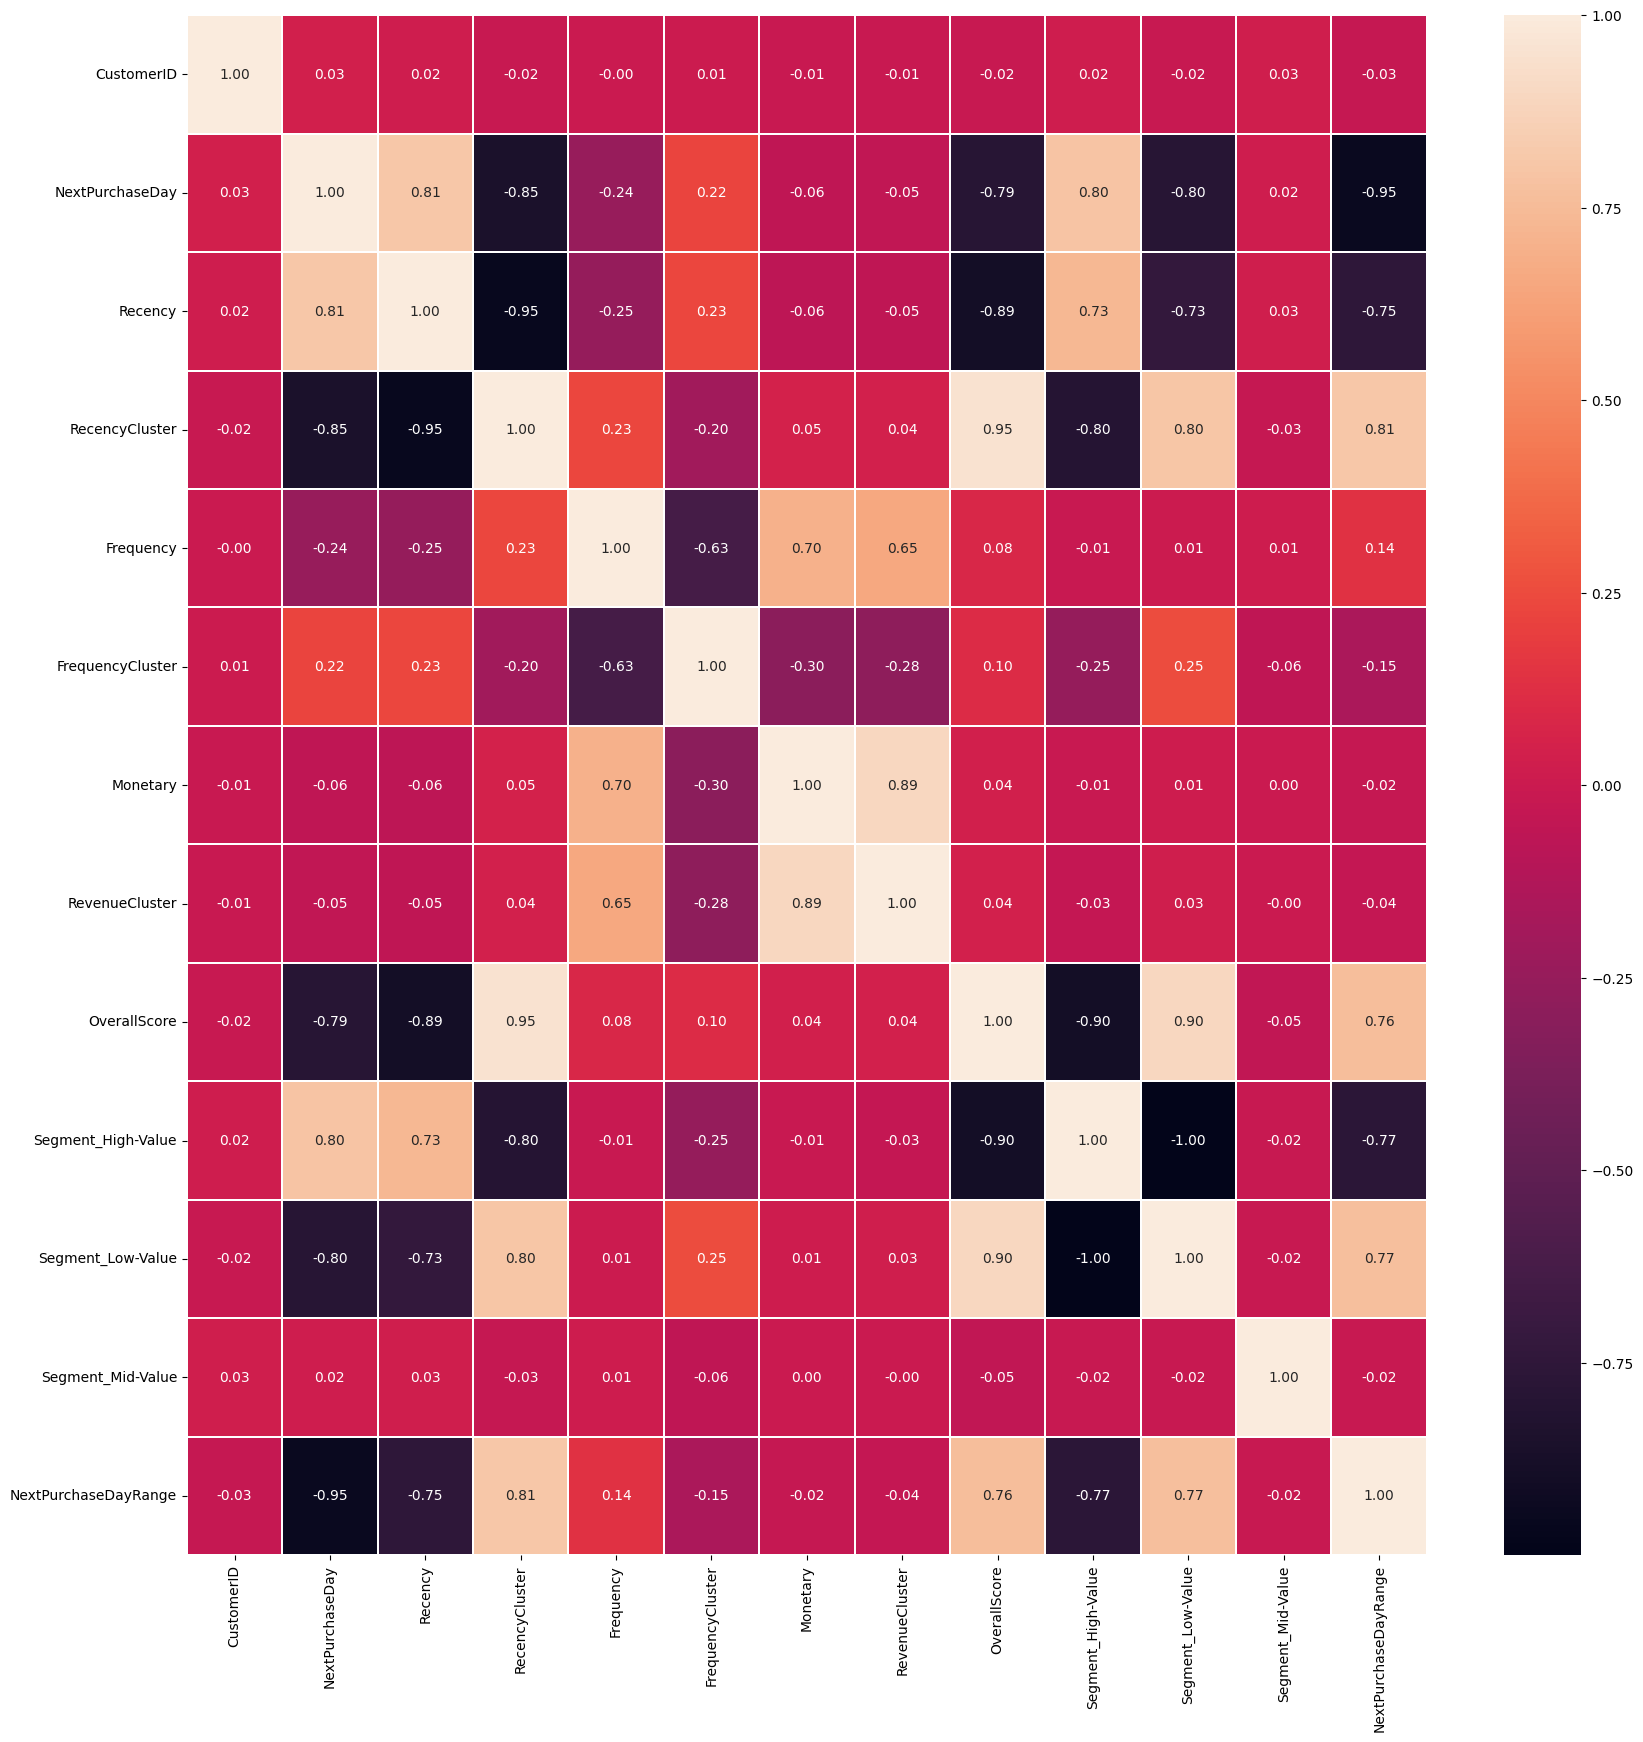

In [73]:
plt.figure(figsize = (20, 20))
sns.heatmap(corr_matrix, annot = True, linewidths=0.2, fmt=".2f");

In [51]:
ctm_class = ctm_class.drop('NextPurchaseDay', axis=1)


In [52]:
X, y = ctm_class.drop('NextPurchaseDayRange', axis=1), ctm_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, shuffle=True)

In [53]:
models = []
models.append(("LogisticRegression", LogisticRegression()))
models.append(("GaussianNB", GaussianNB()))
models.append(("RandomForestClassifier", RandomForestClassifier()))
models.append(("SVC", SVC()))
models.append(("DecisionTreeClassifier", DecisionTreeClassifier()))
models.append(("xgb.XGBClassifier", xgb.XGBClassifier(eval_metric='mlogloss')))
models.append(("KNeighborsClassifier", KNeighborsClassifier()))

In [54]:
pip install multiscorer


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement multiscorer (from versions: none)
ERROR: No matching distribution found for multiscorer


In [55]:
from multiscorer import MultiScorer


In [56]:
scorer = MultiScorer({'accuracy'  : (accuracy_score , {}), 
                      'f1_score'  : (f1_score       , {'pos_label': 3, 'average':'macro'}), 
                      'recall'    : (recall_score   , {'pos_label': 3, 'average':'macro'}), 
                      'precision' : (precision_score, {'pos_label': 3, 'average':'macro'})
                     })
model_scores_dict = {'model_name' : [], 
                     'accuracy'   : [], 
                     'f1_score'   : [], 
                     'recall'     : [], 
                     'precision'  : [],
                     'time'       : []
                    }
for model_name, model in models: 
    model_scores_dict['model_name'].append(model_name)
    kfold = KFold(n_splits=2, random_state=24, shuffle=True)
    start = time.time()
    _ = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scorer)
    cv_result = scorer.get_results()
    
    # For each metric in cv_result.keys()
    for metric_name in cv_result.keys():
        average_score = np.average(cv_result[metric_name])
        model_scores_dict[metric_name].append(average_score)
        #print('%s : %f' %(metric_name, average_score))

    model_scores_dict['time'].append((time.time() - start))
        
model_score_df = pd.DataFrame(model_scores_dict).set_index("model_name")
model_score_df.sort_values(by=["accuracy", "f1_score", "time"], ascending=False)

,accuracy,f1_score,recall,precision,time
model_name,,,,,
xgb.XGBClassifier,0.741691,0.651869,0.723184,0.777036,2.282423
KNeighborsClassifier,0.741656,0.664364,0.725428,0.771795,0.110600
DecisionTreeClassifier,0.700149,0.592434,0.678148,0.742444,0.031733
RandomForestClassifier,0.675347,0.556616,0.650782,0.706280,0.704382
SVC,0.641183,0.506610,0.613644,0.694175,0.443647
LogisticRegression,0.538690,0.357304,0.502285,0.643986,0.077116
GaussianNB,0.537388,0.359492,0.501293,0.583160,0.018074


In [57]:
parameter = {
    'max_depth':range(3,10,2), 
    'min_child_weight':range(1,5,2)
    }

p_grid_search = GridSearchCV(estimator = xgb.XGBClassifier(eval_metric='mlogloss'), 
                             param_grid = parameter, 
                             scoring='accuracy', 
                             n_jobs=-1, 
                             #iid=False, 
                             cv=2
                            )

p_grid_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 5, 2)},
             scoring='accuracy')

In [58]:
p_grid_search.best_params_, p_grid_search.best_score_


({'max_depth': 3, 'min_child_weight': 3}, 0.9490327380952381)

In [59]:
refined_xgb_model = xgb.XGBClassifier(eval_metric='logloss', 
                                      max_depth=list(p_grid_search.best_params_.values())[0]-1, 
                                      min_child_weight=list(p_grid_search.best_params_.values())[-1]+4
                                     ).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'.format(refined_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'.format(refined_xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.97
Accuracy of XGB classifier on test set: 0.96


In [60]:
ref_xgb_pred_y = refined_xgb_model.predict(X_test)


In [61]:
log_reg_pred_y = LogisticRegression().fit(X_train, y_train).predict(X_test)


In [62]:
def get_confusion_matrix(y_test, y_pred):
    """
    Displays the confusion matrix of the input numpy arrays y_test and y_pred.
    
    INPUT: 
        y_test - A numpy array 
        y_pred - A numpy array
        
    OUTPUT:
        NoneType
    """
    
    data = {'y_Actual': y_test, 'y_Predicted': y_pred}

    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    conf_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], 
                              rownames=['Actual'], 
                              colnames=['Predicted'])
    
    sns.heatmap(conf_matrix, annot=True, fmt = "d", cmap="Spectral")
    plt.show()

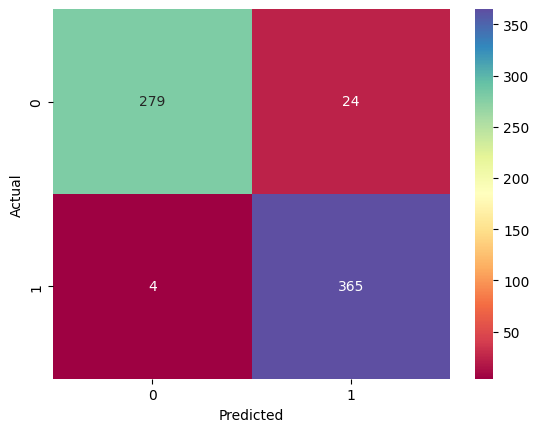

In [63]:
get_confusion_matrix(np.array(y_test), ref_xgb_pred_y)


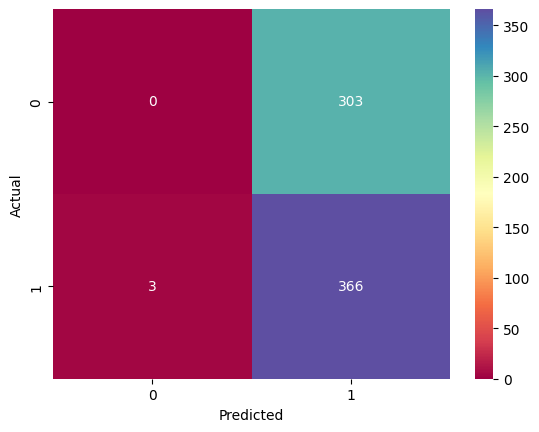

In [64]:
get_confusion_matrix(np.array(y_test), log_reg_pred_y)


In [65]:

ref_xgb_log_reg_dict = {"model_name" : ["xgb.XGBClassifier", "LogisticRegression"], 
                        "accuracy"   : [accuracy_score(y_test, ref_xgb_pred_y), accuracy_score(y_test, log_reg_pred_y)], 
                        "f1_score"   : [f1_score(y_test, ref_xgb_pred_y), f1_score(y_test, log_reg_pred_y)], 
                        "recall"     : [recall_score(y_test, ref_xgb_pred_y), recall_score(y_test, log_reg_pred_y)], 
                        "precision"  : [precision_score(y_test, ref_xgb_pred_y), precision_score(y_test, log_reg_pred_y)]
                       }
# Create a dataframe with ref_xgb_log_reg_dict
ref_xgb_log_reg_df = pd.DataFrame(ref_xgb_log_reg_dict).set_index("model_name")
# Order the dataframe ref_xgb_log_reg_df by the metric values in increasing order
ref_xgb_log_reg_df.sort_values(by=["accuracy", "f1_score", "recall", "precision"], ascending=False)

,accuracy,f1_score,recall,precision
model_name,,,,
xgb.XGBClassifier,0.958333,0.963061,0.98916,0.938303
LogisticRegression,0.544643,0.705202,0.99187,0.547085


In [66]:
import pandas as pd
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
import itertools

df= pd.read_csv("C:\\Users\\LAU\\Desktop\\new proj\\base_data_new_25_new.csv")

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='mixed', dayfirst=True)
df = df.sort_values(by='InvoiceDate')

customer_data = df.groupby('CustomerID')['InvoiceDate'].agg(lambda dates: dates.tolist())

# Define a function to find the best ARIMA model order
def find_best_model_order(purchase_dates):
    p_values = range(0, 3)  # Define range for p
    d_values = range(0, 2)  # Define range for d
    q_values = range(0, 3)  # Define range for q
    best_aic = float("inf")
    best_order = None
    
    for p, d, q in itertools.product(p_values, d_values, q_values):
        order = (p, d, q)
        try:
            model = SARIMAX(purchase_dates, order=order)
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_order = order
        except:
            continue
    
    return best_order

# Defined a function to train ARIMA model and predict next purchase date
def predict_next_purchase(purchase_dates):
    if len(purchase_dates) < 2:
        return None 
    
    try:
        best_order = find_best_model_order(purchase_dates)
        model = SARIMAX(purchase_dates, best_order, seasonal_order=(2, 1, 3, 12))
        model_fit = model.fit()
        
        next_purchase_date = model_fit.forecast(steps=1)[0]
        
        return pd.Timestamp(next_purchase_date)
    except:
        # The next purchase is 30 days from the last purchase
        return purchase_dates[-1] + timedelta(days=30)

next_purchase_dates = customer_data.apply(predict_next_purchase)

print(next_purchase_dates) 



CustomerID
12346   2011-02-17 10:17:00
12347   2011-11-30 12:25:00
12348   2011-10-25 13:13:00
12349   2011-12-21 09:51:00
12350   2011-03-04 16:01:00
                ...        
18280   2011-08-02 09:52:00
18281   2012-01-05 10:53:00
18282   2011-10-08 15:10:00
18283   2011-12-30 12:59:00
18287   2012-01-09 10:23:00
Name: InvoiceDate, Length: 4372, dtype: datetime64[ns]


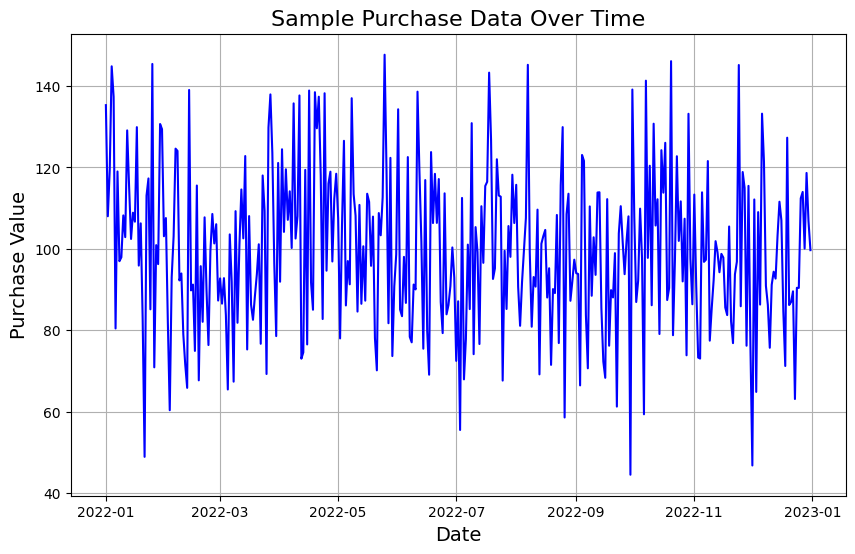

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Generate sample purchase data
np.random.seed(0)
dates = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
purchases = np.random.normal(loc=100, scale=20, size=len(dates))

# Plot the purchase data
plt.figure(figsize=(10, 6))
plt.plot(dates, purchases, color='blue')
plt.title('Sample Purchase Data Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Purchase Value', fontsize=14)
plt.grid(True)
plt.show()


In [68]:
import pandas as pd
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

df= pd.read_csv("C:\\Users\\LAU\\Desktop\\new proj\\base_data_new_25_new.csv")


df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='mixed', dayfirst=True)

df = df.sort_values(by='InvoiceDate')

customer_data = df.groupby('CustomerID')['InvoiceDate'].agg(lambda dates: dates.tolist())

# Define a function to train ARIMA model and predict next purchase date
def predict_next_purchase_arima(purchase_dates):
    if len(purchase_dates) < 2:
        return None  # Not enough data to make a prediction
    
    try:
        model = ARIMA(purchase_dates, order=(1, 1, 1))
        model_fit = model.fit()
        
        next_purchase_date = model_fit.forecast(steps=1)[0]
        
        return pd.Timestamp(next_purchase_date)
    except:
        return purchase_dates[-1] + timedelta(days=30)

def predict_next_purchase_sarima(purchase_dates):
    if len(purchase_dates) < 2:
        return None  
    
    try:
        model = SARIMAX(purchase_dates, order=(2, 1, 3), seasonal_order=(2, 1, 3, 12))
        model_fit = model.fit()
        
        next_purchase_date = model_fit.forecast(steps=1)[0]
        
        return pd.Timestamp(next_purchase_date)
    except:
        return purchase_dates[-1] + timedelta(days=30)


next_purchase_dates_arima = customer_data.apply(predict_next_purchase_arima)
next_purchase_dates_sarima = customer_data.apply(predict_next_purchase_sarima)
print("ARIMA PREDICTION")
print()
print(next_purchase_dates_arima)
print()
print("SARIMAX PREDICTION")
print()
print(next_purchase_dates_sarima)



ARIMA PREDICTION

CustomerID
12346   2011-02-17 10:17:00
12347   2011-11-30 12:25:00
12348   2011-10-25 13:13:00
12349   2011-12-21 09:51:00
12350   2011-03-04 16:01:00
                ...        
18280   2011-08-02 09:52:00
18281   2012-01-05 10:53:00
18282   2011-10-08 15:10:00
18283   2011-12-30 12:59:00
18287   2012-01-09 10:23:00
Name: InvoiceDate, Length: 4372, dtype: datetime64[ns]

SARIMAX PREDICTION

CustomerID
12346   2011-02-17 10:17:00
12347   2011-11-30 12:25:00
12348   2011-10-25 13:13:00
12349   2011-12-21 09:51:00
12350   2011-03-04 16:01:00
                ...        
18280   2011-08-02 09:52:00
18281   2012-01-05 10:53:00
18282   2011-10-08 15:10:00
18283   2011-12-30 12:59:00
18287   2012-01-09 10:23:00
Name: InvoiceDate, Length: 4372, dtype: datetime64[ns]


In [69]:
import pandas as pd
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='mixed', dayfirst=True)

df = df.sort_values(by='InvoiceDate')

# Group by customer and aggregate purchase dates
customer_data = df.groupby('CustomerID')['InvoiceDate'].agg(lambda dates: dates.tolist())

# Defined a function to train ARIMA model and predict next purchase date
def predict_next_purchase(purchase_dates):
    if len(purchase_dates) < 2:
        return None 
    
    try:
        model = ARIMA(purchase_dates, order=(1, 1, 1))
        model_fit = model.fit()
        
        next_purchase_date = model_fit.forecast(steps=1)[0]
        
        return pd.Timestamp(next_purchase_date)
    except:
        #The next purchase is 30 days from the last purchase
        return purchase_dates[-1] + timedelta(days=30)

# Apply the function to each customer's purchase dates to predict next purchase date
next_purchase_dates = customer_data.apply(predict_next_purchase)

print(next_purchase_dates)

CustomerID
12346   2011-02-17 10:17:00
12347   2011-11-30 12:25:00
12348   2011-10-25 13:13:00
12349   2011-12-21 09:51:00
12350   2011-03-04 16:01:00
                ...        
18280   2011-08-02 09:52:00
18281   2012-01-05 10:53:00
18282   2011-10-08 15:10:00
18283   2011-12-30 12:59:00
18287   2012-01-09 10:23:00
Name: InvoiceDate, Length: 4372, dtype: datetime64[ns]
